# Regresión lineal

Importamos las librerías que vamos a utilizar

In [1]:
import numpy as np #operaciones matriciales y con vectores
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn import datasets, linear_model #datasets y modelos de aprendizaje automático (ML)
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

from scipy import stats #para poder hacer cálculos científicos --> valores p
import statsmodels.api as sm

## Preparación de los datos

Vamos a cargar en un **dataframe** de ***pandas*** un dataset muy utilizado para explicar conceptos de aprendizaje del repositorio de Machine Learning alojado en la Universidad De California en Irvine (UCI), que contiene información acerca de automóviles y su rendimiento en millas por galón (MPG).

In [2]:
data = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original",
                   delim_whitespace = True, header=None,
                   names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
                            'model', 'origin', 'car_name'])
print(data.shape)
data.head()

(406, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car_name
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino


Hay 406 registros con 9 variables.
Vamos a analizar si hay problemas de datos con respecto a valores faltantes y outliers

In [3]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.50,23.0,29.000,46.6
cylinders,406.0,5.475369,1.712160,3.0,4.00,4.0,8.000,8.0
displacement,406.0,194.779557,104.922458,68.0,105.00,151.0,302.000,455.0
horsepower,400.0,105.082500,38.768779,46.0,75.75,95.0,130.000,230.0
weight,406.0,2979.413793,847.004328,1613.0,2226.50,2822.5,3618.250,5140.0
acceleration,406.0,15.519704,2.803359,8.0,13.70,15.5,17.175,24.8
model,406.0,75.921182,3.748737,70.0,73.00,76.0,79.000,82.0
origin,406.0,1.568966,0.797479,1.0,1.00,1.0,2.000,3.0


Al parecer a primera vista no hay outliers, pero si hay valores faltantes (columna count no es de 406 para todas las variables).

Además podemos ver que las escalas de las variables son bastante disparejas, con los valores de peso que van de 1600 a 5100, y los de los cilindros de 3 a 8. Es necesario reescalar los datos para otorgarle la misma importancia a cada variable dentro del modelo.

### Vamos a ver que variables tienen valores faltantes

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       406 non-null float64
displacement    406 non-null float64
horsepower      400 non-null float64
weight          406 non-null float64
acceleration    406 non-null float64
model           406 non-null float64
origin          406 non-null float64
car_name        406 non-null object
dtypes: float64(8), object(1)
memory usage: 28.6+ KB


In [5]:
print(pd.isnull(data).any(0)) #el 0 implica cualquier columna, si quisieramos las filas utilizamos 1
print("Las columnas que tienen valores faltantes son: ",pd.isnull(data).any(0).nonzero()[0])
print("y corresponden a: ", data.columns[pd.isnull(data).any(0).nonzero()[0]])

mpg              True
cylinders       False
displacement    False
horsepower       True
weight          False
acceleration    False
model           False
origin          False
car_name        False
dtype: bool
Las columnas que tienen valores faltantes son:  [0 3]
y corresponden a:  Index(['mpg', 'horsepower'], dtype='object')


Tanto mpg como horsepower tienen valores faltantes, pero no son muchos.
Hay al menos 8 registros con valores faltantes.

Podemos encontrar los índices de las filas con los valores faltantes y eliminarlos del dataset.
También podemos directamente eliminarlos con un comando de pandas.
Vamos a hacer las dos operaciones.

Encontramos entonces los índices con registros incompletos.

In [6]:
indices = pd.isnull(data).any(1).nonzero()[0]
print("Hay {} registros incompletos: ".format(len(indices)), indices)

Hay 14 registros incompletos:  [ 10  11  12  13  14  17  38  39 133 337 343 361 367 382]


In [7]:
data2 = data.drop(indices)
print("Datos originales: ", data.shape)
print("Datos limpios y completos: ", data2.shape)
print("Se eliminaron {} registos".format(data.shape[0] - data2.shape[0]))

Datos originales:  (406, 9)
Datos limpios y completos:  (392, 9)
Se eliminaron 14 registos


También lo podemos hacer directamente con **dropna**

In [8]:
data2 = data.dropna()
print("Datos originales: ", data.shape)
print("Datos limpios y completos: ", data2.shape)
print("Se eliminaron {} registos".format(data.shape[0] - data2.shape[0]))

Datos originales:  (406, 9)
Datos limpios y completos:  (392, 9)
Se eliminaron 14 registos


In [9]:
data = data2

## Aprendizaje del modelo de regresión

Vamos a ignorar por ahora el hecho de que las variables no siguen la misma escala. Más adelante nos ocuparemos de ese problema.

Vamos a crear un modelo de regresión lineal que permita obtener *mpg* a partir de algunas (5 de ellas) de las demás variables independientes del dataset

In [10]:
indep_vars = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']
dep_vars = ['mpg']

In [11]:
indep_data = data[indep_vars]
dep_data = data[dep_vars]

Tenemos un dataframe con los datos de las variables independientes y otro con los de la variable dependiente.

Vamos ahora a partir cada dataframe en 2 de manera aleatoria: 67% de los datos se utilizarán para aprender el modelo, y 33 para evaluarlo.

In [12]:
train_x, test_x, train_y, test_y = train_test_split(indep_data, dep_data, test_size=0.33, random_state=42)

In [13]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(262, 5)
(262, 1)
(130, 5)
(130, 1)


Ya tenemos todos los datos preparados para lanzar el modelo de regresión lineal a partir de los datos de entrenamiento.
Lanzamos el método **fit** que se encarga de encontrar la mejor línea de ajuste, y consultamos los diferentes coeficientes encontrados para las variables independientes.

In [14]:
regr = linear_model.LinearRegression(normalize=True)
regr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

Se estableció que se va a utilizar un modelo de regresión lineal, que por defecto incluye un coeficiente para la intercepción con la ordenada en el origen, y especificamos que deseamos normalizar los datos de las variables predictivas.

In [15]:
for var, coef in zip(indep_vars, np.squeeze(regr.coef_)):
    print("{}: {}".format(var, coef))
print("intercepción: {}".format(np.squeeze(regr.intercept_)))

cylinders: -0.2622622212088985
displacement: -0.001956299665368273
horsepower: -0.05984964007927196
weight: -0.004940174279273555
acceleration: 0.004033488575202949
intercepción: 46.532369302492924


## Predicción

Vamos a predecir la variable dependiente ajustada según el modelo para los datos de entrenamiento y para los datos de test

In [16]:
train_y_pred = regr.predict(train_x)
test_y_pred = regr.predict(test_x)
print(train_y_pred.shape)
print(test_y_pred.shape)

(262, 1)
(130, 1)


Veamos como nos va con las métricas de bondad de ajuste

In [17]:
print("MSE (train): %.4f" % mean_squared_error(train_y, train_y_pred))
print("MSE (test) : %.4f" % mean_squared_error(test_y, test_y_pred))
print('R2  (train): %.4f' % r2_score(train_y, train_y_pred))
print('R2  (test) : %.4f' % r2_score(test_y, test_y_pred))

MSE (train): 17.3145
MSE (test) : 19.7149
R2  (train): 0.7323
R2  (test) : 0.6267


Encontramos que la predicción con los datos de entrenamiento nos da mejores resultados que con los datos de aprendizaje: por un lado el MSE es menor y por otro lado el R2 es mayor con el training set.

Esto muestra que utilizar el mismo set de datos con el que se entrenó al modelo para evaluarlo causa una subestimación del error del modelo.

scikit-learn no ofrece el cálculo del R2 ajustado (viva Python!), por lo que lo calculamos a mano:

In [18]:
r2_aj_train = 1 - (1-r2_score(train_y, train_y_pred))*(len(train_y)-1) / (len(train_y) - train_x.shape[1] - 1)
print('R2 adj (train): %.4f' %r2_aj_train)
r2_aj_test = 1 - (1-r2_score(test_y, test_y_pred))*(len(test_y)-1) / (len(test_y) - test_x.shape[1] - 1)
print('R2 adj (train): %.4f' %r2_aj_test)

R2 adj (train): 0.7270
R2 adj (train): 0.6116


El valor del R2 ajustado corrige el valor del R2 con respecto a la complejidad dada por el número de variables independientes utilizadas, y permite comparar modelos de diferente número de predictores.

## Análisis de los coeficientes 

In [19]:
indep_vars

['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']

Para poder establecer la significancia de los coeficientes, es necesario realizar pruebas de hipótesis de los coeficientes de cada variable predictiva, comparándolos contra 0.

El problema es que **scikit-learn** no realiza estas pruebas, y no incluye muchas de las métricas (como el R2 ajustado), y hay que utilizar el package **statsmodel** (viva Python!).


Este proceso es bastante complicado, por lo que es a veces mejor conocer cómo obtener los valores p directamente, por lo que usamos el package **statsmodels**. Este paquete requiere adicionar una constante inicial a los datos predictores (correspondiente al valor del intercepto).

In [20]:
train_x2 = sm.add_constant(train_x)
print(train_x2.head())

     const  cylinders  displacement  horsepower  weight  acceleration
376    1.0        4.0         112.0        88.0  2640.0          18.6
189    1.0        4.0         107.0        86.0  2464.0          15.5
127    1.0        4.0         121.0       112.0  2868.0          15.5
316    1.0        4.0          98.0        76.0  2144.0          14.7
228    1.0        8.0         305.0       145.0  3880.0          12.5


In [21]:
modeloStats = sm.OLS(train_y, train_x2)
results = modeloStats.fit();
#Consultamos la calidad del modelo a partir de sus estadísticas
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     140.0
Date:                Tue, 10 Sep 2019   Prob (F-statistic):           3.89e-71
Time:                        15:02:52   Log-Likelihood:                -745.31
No. Observations:                 262   AIC:                             1503.
Df Residuals:                     256   BIC:                             1524.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           46.5324      3.165     14.703      0.000      40.300      52.765
cylinders       -0.2623      0.509     -0.515      0.607      -1.265       0.741
displacement    -0.0020      0.011     -0.176      0.860      -0.024       0.020
horsepower      -0.0598      0.020     -3.057      0.002      -0.098      -0.021
weight          -0.0049      0.001     -5.150      0.000      -0.007      -0.003
acceleration     0.0040      0.148      0.027      0.978      -0.287       0.295
==============================================================================
Omnibus:                       28.170   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.303
Skew:                           0.733   Prob(JB):                     7.94e-09
Kurtosis:                       4.126   Cond. No.                     3.82e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.82e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Encontramos que los parámetros cylinders, displacement y acceleration (t>0.5) no son para nada significativos en el modelo.

También podemos ver que puede que haya problemas de multicolinearidad, como lo establece la 2a advertencia. Vamos a analizar la correlación entre las variables incluidas en el modelo.

In [22]:
# Calculamos la matriz de correlaciones
corr = train_x.join(train_y).corr()
corr

,cylinders,displacement,horsepower,weight,acceleration,mpg
cylinders,1.000000,0.955308,0.853370,0.894257,-0.528679,-0.790598
displacement,0.955308,1.000000,0.893969,0.929472,-0.556061,-0.819177
horsepower,0.853370,0.893969,1.000000,0.855623,-0.698691,-0.802900
weight,0.894257,0.929472,0.855623,1.000000,-0.420763,-0.839409
acceleration,-0.528679,-0.556061,-0.698691,-0.420763,1.000000,0.464144
mpg,-0.790598,-0.819177,-0.802900,-0.839409,0.464144,1.000000


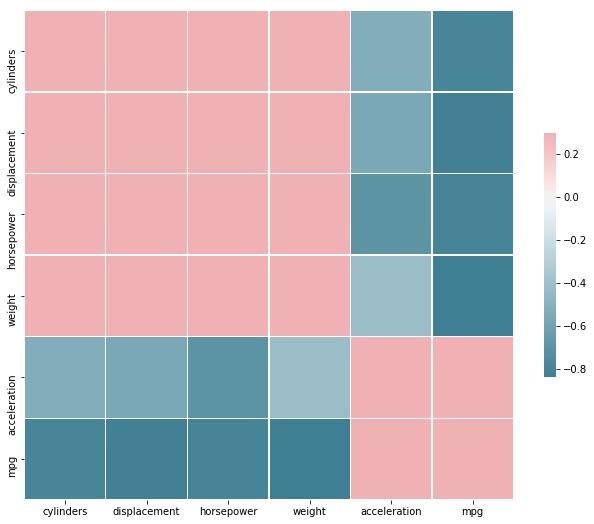

In [23]:
## Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Encontramos que *aceleration* está bastante correlacionada con las primeras cuatro variables independientes. Podríamos eliminarla y correr el modelo otra vez, pero vamos a preferir seguir un proceso más organizado de forward stepwise.

## Escogencia de variables usando forward stepwise

Empezamos por escoger como primera variable *weight*, pues es la que tiene la correlación más importante con *mpg*.

In [24]:
train_x2 = train_x[['weight']]
train_x2 = sm.add_constant(train_x2)
modeloStats = sm.OLS(train_y, train_x2)
results = modeloStats.fit();
print(results.rsquared_adj)

0.7034711364975179


Partimos entonces de un modelo que solo incluyendo la variable *weight* obtiene un R2 ajustado de 0.703. Vamos a continuar la búsqueda del mejor modelo siguiendo el heurístico de forward stepwise.

**<span style="color:red">Taller:</span>** 
<span style="color:red">Buscar un mejor modelo intentando diferentes combinaciones de variables predictivas:</span>
- <span style="color:red">Utilizar el R2 Ajustado como criterio de evaluación.</span>
- <span style="color:red">Agregar las variables predictivas que mejor explican la variable dependiente MPG de manera iterativa utilizando la técnica de **forward stepwise** regression.</span>

In [ ]:
...
...
...
... TODO
...
...

## Escogencia de variables usando backward stepwise

Empezamos por escoger todas la variables para crear un modelo inicial.

In [ ]:
train_x3 = train_x[['weight', 'cylinders', 'displacement', 'horsepower', 'acceleration']]
train_x3 = sm.add_constant(train_x3)
modeloStats = sm.OLS(train_y, train_x3)
results = modeloStats.fit();
print(results.rsquared_adj)

Partimos entonces de un modelo que incluye todas las variables, y que obtiene un R2 ajustado de 0.727. Vamos a continuar la búsqueda del mejor modelo siguiendo el heurístico de backward stepwise.

**<span style="color:red">Taller:</span>** 
<span style="color:red">Buscar un mejor modelo intentando diferentes combinaciones de variables predictivas:</span>
- <span style="color:red">Utilizar el R2 Ajustado como criterio de evaluación.</span>
- <span style="color:red">Eliminar las variables predictivas que impiden obtener un mejor modelos al agregar ruido, utilizando la técnica de **backward stepwise** regression.</span>
</span>

In [ ]:
...
...
...
... TODO
...
...

## Regularización: Ridge

Vamos a aplicar regularización a partir del modelo de **Ridge** regression.
La penalización en este modelo se controla a partir del parámetro alpha en la clase **Ridge** de scikit-learn.

### Comparación del modelo de regresión lineal vs un ridge regression específico

Vamos a volver a entrenar el modelo de regresión lineal simple las 5 variables numéricas.

In [25]:
regr = linear_model.LinearRegression(normalize=True)
regr.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [26]:
train_y_pred = regr.predict(train_x)
test_y_pred = regr.predict(test_x)
train_y_pred[0:5]
print("MSE (train): %.4f" % mean_squared_error(train_y, train_y_pred))
print("MSE (test) : %.4f" % mean_squared_error(test_y, test_y_pred))
print('R2  (train): %.4f' % r2_score(train_y, train_y_pred))
print('R2  (test) : %.4f' % r2_score(test_y, test_y_pred))
r2_aj_train = 1 - (1-r2_score(train_y, train_y_pred))*(len(train_y)-1) / (len(train_y) - train_x.shape[1] - 1)
print('R2 adj (train): %.4f' %r2_aj_train)
r2_aj_test = 1 - (1-r2_score(test_y, test_y_pred))*(len(test_y)-1) / (len(test_y) - test_x.shape[1] - 1)
print('R2 adj (test): %.4f' %r2_aj_test)

MSE (train): 17.3145
MSE (test) : 19.7149
R2  (train): 0.7323
R2  (test) : 0.6267
R2 adj (train): 0.7270
R2 adj (test): 0.6116


Ahora vamos a lanzar una regresión Ridge con un valor cualquiera de alpha (0.1).

In [27]:
ridgereg = linear_model.Ridge(alpha=0.1, fit_intercept=True, normalize=True)
ridgereg.fit(train_x, train_y)

train_y_pred = ridgereg.predict(train_x)
test_y_pred = ridgereg.predict(test_x)
train_y_pred[0:5]
print("MSE (train): %.4f" % mean_squared_error(train_y, train_y_pred))
print("MSE (test) : %.4f" % mean_squared_error(test_y, test_y_pred))
print('R2  (train): %.4f' % r2_score(train_y, train_y_pred))
print('R2  (test) : %.4f' % r2_score(test_y, test_y_pred))
r2_aj_train = 1 - (1-r2_score(train_y, train_y_pred))*(len(train_y)-1) / (len(train_y) - train_x.shape[1] - 1)
print('R2 adj (train): %.4f' %r2_aj_train)
r2_aj_test = 1 - (1-r2_score(test_y, test_y_pred))*(len(test_y)-1) / (len(test_y) - test_x.shape[1] - 1)
print('R2 adj (test): %.4f' %r2_aj_test)

MSE (train): 17.6003
MSE (test) : 19.5876
R2  (train): 0.7278
R2  (test) : 0.6291
R2 adj (train): 0.7225
R2 adj (test): 0.6141


Nótese como se mejora el score en el conjunto de test.
Lo que estamos haciendo es mejorando la generalización del modelo a datos nuevos.

### Análisis de los modelos para diferentes grados de penalización

Se va a controlar el parámetro *alpha* que controla el componente de penalización de la complejidad de los modelos de Ridge regression.
Se crea un conjunto de valores de *alpha* siguiendo una escala logarítmica que se van a utilizar para analizar como varían los coeficientes.

In [28]:
n_alphas = 200
alphas = np.logspace(-2, 1, n_alphas)
alphas[:5]

array([0.01      , 0.01035322, 0.01071891, 0.01109752, 0.01148951])

Vamos a recorrer el array de valores de alpha, y vamos a aprender un modelo de Ridge para configuración, guardando en el array *coef* los coeficientes de las variables independientes de cada modelo.

In [29]:
coefs = []
r2adj_train_vec = []
r2adj_test_vec = []

for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True, normalize=True)
    ridge.fit(train_x, train_y)
    coefs.append(ridge.coef_)
    train_y_pred = ridge.predict(train_x)
    test_y_pred = ridge.predict(test_x)
    r2_aj_train = 1 - (1-r2_score(train_y, train_y_pred))*(len(train_y)-1) / (len(train_y) - train_x.shape[1] - 1)
    r2_aj_test = 1 - (1-r2_score(test_y, test_y_pred))*(len(test_y)-1) / (len(test_y) - test_x.shape[1] - 1)
    r2adj_train_vec.append(r2_aj_train)
    r2adj_test_vec.append(r2_aj_test)

Vamos ahora a plotear los valores de las métricas con respecto al valor del alpha.

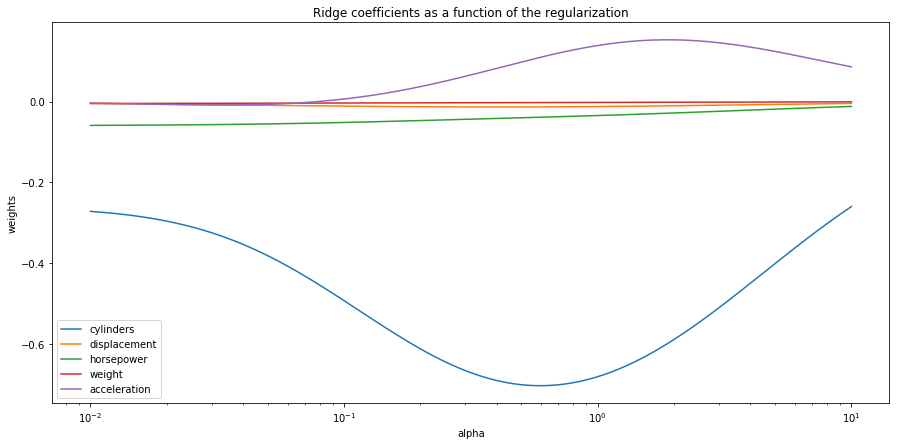

In [39]:
plt.figure(figsize=(15,7))
ax = plt.gca() # get current axis
plt.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis -> cambiar -1 por 1 para leerlo como una persona normal
ax.set_xlim(ax.get_xlim()[::1])
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.legend(indep_vars)

¿Cuáles son las variables mas importantes? R// cylinders y acceleration

Vamos ahora analizar los valores de r2 ajustado en los dataset de entrenamiento y test.

Creamos un array con los valores de las dos series uno a uno para poder plotearlos al mismo tiempo.

In [31]:
t1 = np.array(r2adj_train_vec)
t1 = t1[:, np.newaxis]
print("train: ", t1.shape)

t2 = np.array(r2adj_test_vec)
t2 = t2[:, np.newaxis]
print("test: ", t2.shape)

r2adj_vecs = np.concatenate((t1, t2), axis=1)
print("concatenación: ", r2adj_vecs.shape)

train:  (200, 1)
test:  (200, 1)
concatenación:  (200, 2)


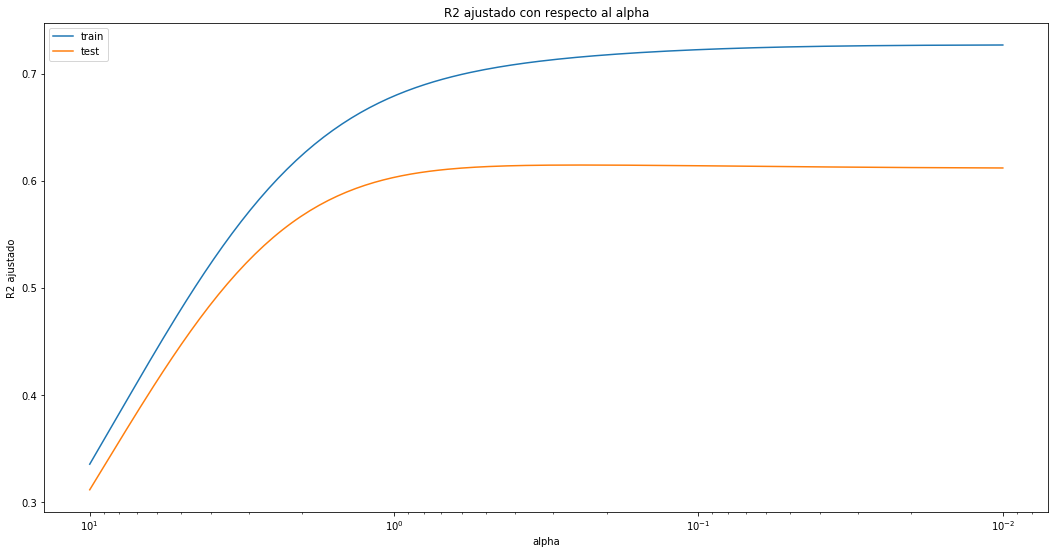

In [32]:
plt.figure(figsize=(18,9))
ax = plt.gca()
plt.plot(alphas, r2adj_vecs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('R2 ajustado')
plt.title('R2 ajustado con respecto al alpha')
plt.legend(['train', 'test'])

Encontramos que para un valor de alpha por debajo de $10^0=1$, se obtiene el valor máximal de R2 ajustado para el conjunto de test.
Vamos a utilizar CV para comparar valores de alpha cercanos. 

In [33]:
indiceMax = np.argmax(r2adj_test_vec)
r2Max = r2adj_test_vec[indiceMax]
alphaMax = alphas[indiceMax]
print("El nivel máximo de R2 es {}, y se alcanza con un alpha de {}".format(r2Max, alphaMax))

El nivel máximo de R2 es 0.614798269280139, y se alcanza con un alpha de 0.24374441501222205


In [34]:
ridgereg = linear_model.Ridge(alpha=alphaMax, normalize=True)
ridgereg.fit(train_x, train_y)

train_y_pred = ridgereg.predict(train_x)
test_y_pred = ridgereg.predict(test_x)
train_y_pred[0:5]
print("MSE (train): %.4f" % mean_squared_error(train_y, train_y_pred))
print("MSE (test) : %.4f" % mean_squared_error(test_y, test_y_pred))
print('R2  (train): %.4f' % r2_score(train_y, train_y_pred))
print('R2  (test) : %.4f' % r2_score(test_y, test_y_pred))
r2_aj_train = 1 - (1-r2_score(train_y, train_y_pred))*(len(train_y)-1) / (len(train_y) - train_x.shape[1] - 1)
print('R2 adj (train): %.4f' %r2_aj_train)
r2_aj_test = 1 - (1-r2_score(test_y, test_y_pred))*(len(test_y)-1) / (len(test_y) - test_x.shape[1] - 1)
print('R2 adj (test): %.4f' %r2_aj_test)

MSE (train): 18.0331
MSE (test) : 19.5538
R2  (train): 0.7211
R2  (test) : 0.6297
R2 adj (train): 0.7157
R2 adj (test): 0.6148


In [35]:
ridgereg.coef_

array([[-0.64070544, -0.01294795, -0.04546692, -0.00279541,  0.04896332]])

In [36]:
train_x.columns

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration'], dtype='object')

## Regularización: Lasso

Vamos ahora utilizar la regularización del modelo de Lasso. Utilizamos un valor de alpha específico (1).

In [40]:
lassoreg = linear_model.Lasso(alpha=0.1, normalize=True)
lassoreg.fit(train_x, train_y)

train_y_pred = lassoreg.predict(train_x)
test_y_pred = lassoreg.predict(test_x)
print("MSE (train): %.4f" % mean_squared_error(train_y, train_y_pred))
print("MSE (test) : %.4f" % mean_squared_error(test_y, test_y_pred))
print('R2  (train): %.4f' % r2_score(train_y, train_y_pred))
print('R2  (test) : %.4f' % r2_score(test_y, test_y_pred))
r2_aj_train = 1 - (1-r2_score(train_y, train_y_pred))*(len(train_y)-1) / (len(train_y) - train_x.shape[1] - 1)
print('R2 adj (train): %.4f' %r2_aj_train)
r2_aj_test = 1 - (1-r2_score(test_y, test_y_pred))*(len(test_y)-1) / (len(test_y) - test_x.shape[1] - 1)
print('R2 adj (test): %.4f' %r2_aj_test)

MSE (train): 20.1638
MSE (test) : 18.7344
R2  (train): 0.6882
R2  (test) : 0.6452
R2 adj (train): 0.6821
R2 adj (test): 0.6309


In [41]:
lassoreg.coef_

array([-0.        , -0.00329475, -0.04012183, -0.00412574,  0.        ])

In [42]:
train_x.columns

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration'], dtype='object')

Vemos que hay variables predictivas que se ignoran con la regresión Lasso (cylinders y acceleration).

In [43]:
#Vamos ahora utilizar la regularización del modelo de Lasso. Utilizamos un valor de alpha específico (1).

lassoreg = linear_model.Lasso(alpha=0.1, normalize=True)
lassoreg.fit(train_x, train_y)

train_y_pred = lassoreg.predict(train_x)
test_y_pred = lassoreg.predict(test_x)
print("MSE (train): %.4f" % mean_squared_error(train_y, train_y_pred))
print("MSE (test) : %.4f" % mean_squared_error(test_y, test_y_pred))
print('R2  (train): %.4f' % r2_score(train_y, train_y_pred))
print('R2  (test) : %.4f' % r2_score(test_y, test_y_pred))
r2_aj_train = 1 - (1-r2_score(train_y, train_y_pred))*(len(train_y)-1) / (len(train_y) - train_x.shape[1] - 1)
print('R2 adj (train): %.4f' %r2_aj_train)
r2_aj_test = 1 - (1-r2_score(test_y, test_y_pred))*(len(test_y)-1) / (len(test_y) - test_x.shape[1] - 1)
print('R2 adj (test): %.4f' %r2_aj_test)

lassoreg.coef_

train_x.columns

#Vemos que hay variables predictivas que se ignoran con la regresión Lasso (cylinders y acceleration).

MSE (train): 20.1638
MSE (test) : 18.7344
R2  (train): 0.6882
R2  (test) : 0.6452
R2 adj (train): 0.6821
R2 adj (test): 0.6309


Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration'], dtype='object')

**<span style="color:red">Taller:</span>** 
<span style="color:red">Buscar el mejor modelo de regresión Lasso, intentando diferentes valores de alpha. Utilizar el R2 Ajustado sobre el test set como criterio de evaluación.</span>

In [ ]:
...
...
...
... TODO
...
...

In [50]:
coefs = []
r2adj_train_vec = []
r2adj_test_vec = []

for a in alphas:
    lasso = linear_model.Lasso(alpha=a, fit_intercept=True, normalize=True)
    lasso.fit(train_x, train_y)
    coefs.append(lasso.coef_)
    train_y_pred = lasso.predict(train_x)
    test_y_pred = lasso.predict(test_x)
    r2_aj_train = 1 - (1-r2_score(train_y, train_y_pred))*(len(train_y)-1) / (len(train_y) - train_x.shape[1] - 1)
    r2_aj_test = 1 - (1-r2_score(test_y, test_y_pred))*(len(test_y)-1) / (len(test_y) - test_x.shape[1] - 1)
    r2adj_train_vec.append(r2_aj_train)
    r2adj_test_vec.append(r2_aj_test)

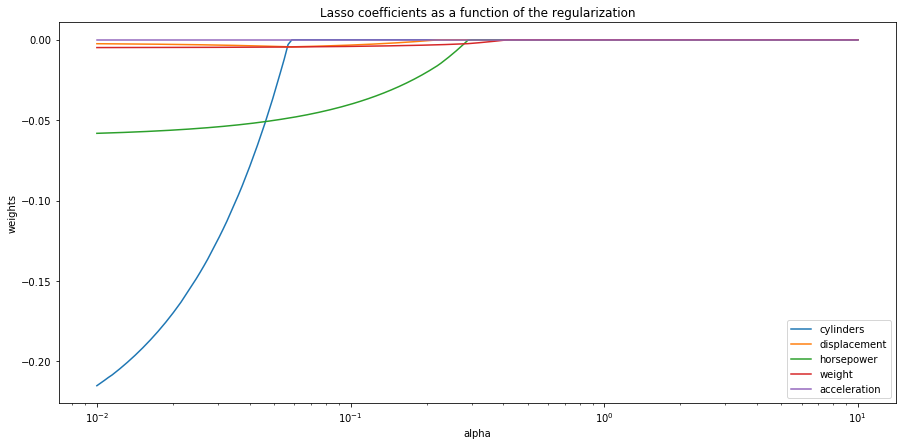

In [51]:
plt.figure(figsize=(15,7))
ax = plt.gca() # get current axis
plt.plot(alphas, np.squeeze(coefs))
ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis -> cambiar -1 por 1 para leerlo como una persona normal
ax.set_xlim(ax.get_xlim()[::1])
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.legend(indep_vars)